In [2]:
# Standard Library Imports
import os
import sys
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from typing import Union
# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
                
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Logging
logger = utils.get_notebook_logger()

Matplotlib created a temporary config/cache directory at /jobfs/110244217.gadi-pbs/matplotlib-0hvrwt7v because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:33851
-   dashboard at:        /proxy/43845/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:34795'
-         Start Nanny at: 'tcp://127.0.0.1:37117'
-         Start Nanny at: 'tcp://127.0.0.1:45499'
-         Start Nanny at: 'tcp://127.0.0.1:36125'
-         Start Nanny at: 'tcp://127.0.0.1:43117'
-         Start Nanny at: 'tcp://127.0.0.1:43919'
-         Start Nanny at: 'tcp://127.0.0.1:43409'
- Register worker <WorkerState 'tcp://127.0.0.1:46751', name: 4, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46751
- Starting established connection to tcp://127.0.0.1:47670
- Register worker <WorkerState 'tcp://127.0.0.1:36751', name: 0, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:36751
- Starting established connection to tcp://127.0.0.1:47698
- Register worker <WorkerState 'tcp://127.0.0.1:45071', name: 5, status

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43845/status,
Dashboard: /proxy/43845/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33851,Workers: 7
Dashboard: /proxy/43845/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:36751,Total threads: 4
Dashboard: /proxy/39805/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:34795,


In [4]:
# client.close()

In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# BEST Data Set

In [6]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [7]:
ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

ds = ds.rename({'latitude':'lat', 'longitude': 'lon'})

ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(ds.time.values))

0.3.0


In [8]:
ds = ds.resample(time='Y').mean()

In [9]:
ds_smean = ds.clima.space_mean()

In [10]:
ds_smean = ds_smean.compute()

In [11]:
ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [12]:
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = ds_smean.where(ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [13]:
ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

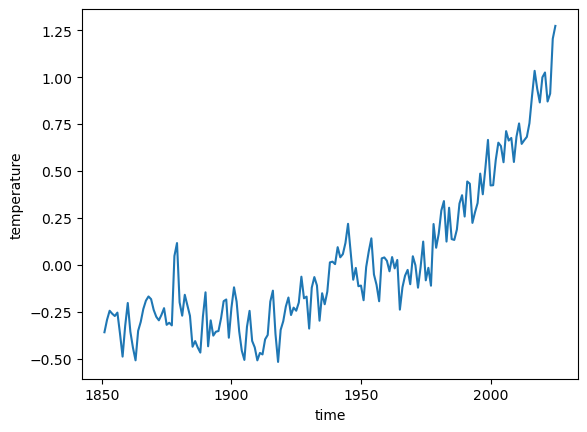

In [14]:
ds_smean.plot()

# Signal-to-Noise

## Gradient

In [15]:
sn.signal_to_noise

<function signal_to_noise.signal_to_noise(window: int, da: xarray.core.dataarray.DataArray, da_for_noise: Optional[xarray.core.dataarray.DataArray] = None, rolling_noise: bool = True, method: str = 'gradient', logginglevel='ERROR', detrend: bool = True, detrend_kwargs: Dict = {}, time_slice: Tuple[int] = None, center=True, return_all=False) -> xarray.core.dataarray.DataArray>

In [16]:
# ds_smean = ds_smean.where(ds_smean.time.dt.year.isin(np.arange(1900, 2025)), drop=True)

In [17]:
ds_sn = sn.signal_to_noise(20, ds_smean, detrend_kwargs={'method':'polynomial', 'order':3}, 
                          return_all=True)

20, 

In [18]:
ds_sn = ds_sn.compute()

In [19]:
ds_sn

<xarray.Dataset>
Dimensions:          (time: 175, window: 1)
Coordinates:
  * time             (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
  * window           (window) int64 20
Data variables:
    signal           (window, time) float64 0.085 0.07441 0.07686 ... nan nan
    da_for_noise     (time) float64 -0.04216 0.02232 0.06882 ... 0.1613 0.2027
    noise            (window, time) float64 0.09403 0.09353 0.09345 ... nan nan
    signal_to_noise  (window, time) float64 0.904 0.7956 0.8225 ... nan nan nan

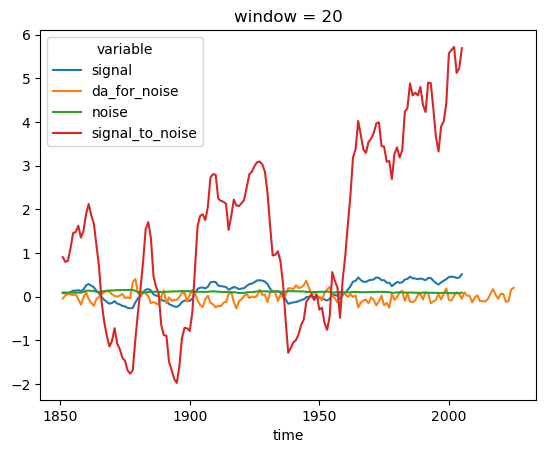

In [20]:
ds_sn.to_array().plot(hue='variable');

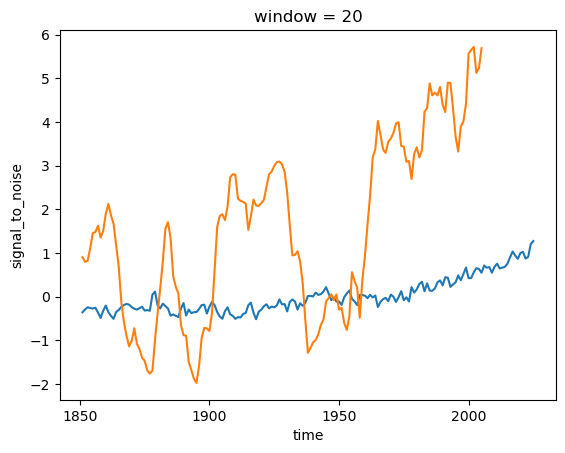

In [21]:
ds_smean.plot()
ds_sn.signal_to_noise.plot()

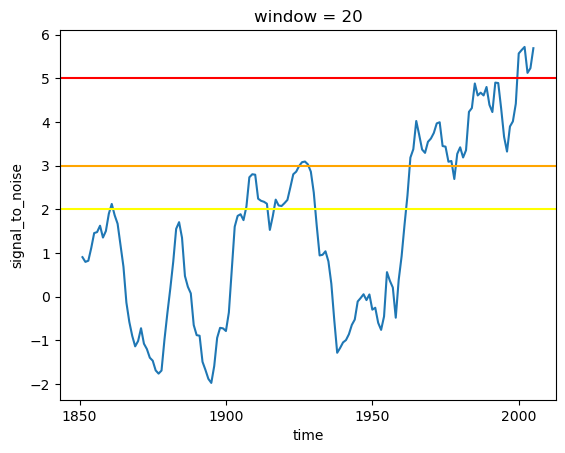

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ds_sn.signal_to_noise.plot(ax=ax)
ax.axhline(2, color='yellow')
ax.axhline(3, color='orange')
ax.axhline(5, color='red')

In [23]:
ds_smean_lowess = stats.trend_fit(ds_smean, method='LOWESS', lowess_window=40)

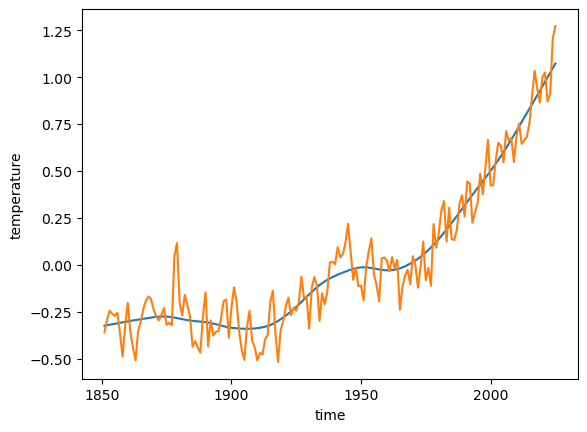

In [24]:
fig, ax = plt.subplots()
ds_smean_lowess.plot(ax=ax)
ds_smean.plot(ax=ax)

In [25]:
ds_smean_detrend_lowess = ds_smean - ds_smean_lowess

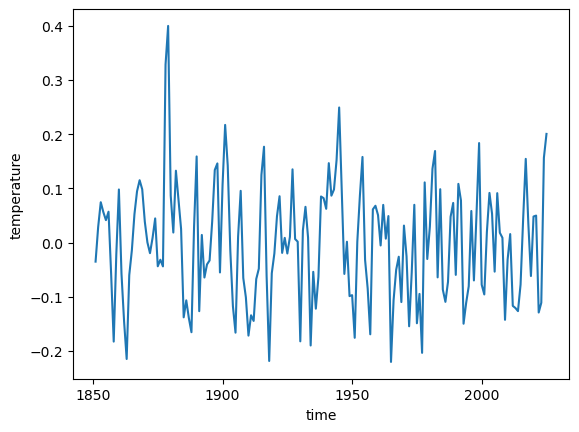

In [26]:
ds_smean_detrend_lowess.plot()

In [27]:
ax.axhline(2, color='yellow')
ax.axhline(3, color='orange')
ax.axhline(5, color='red')

In [28]:
ds_sn_smooth = sn.signal_to_noise(20, ds_smean_lowess, da_for_noise=ds_smean_detrend_lowess, 
                          return_all=True, center=False)

20, 

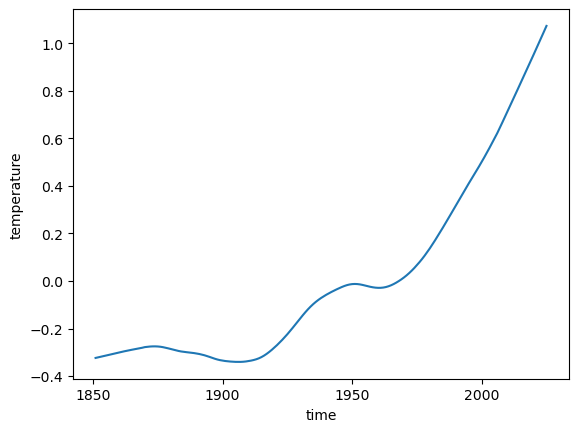

In [29]:
ds_smean_lowess.plot()

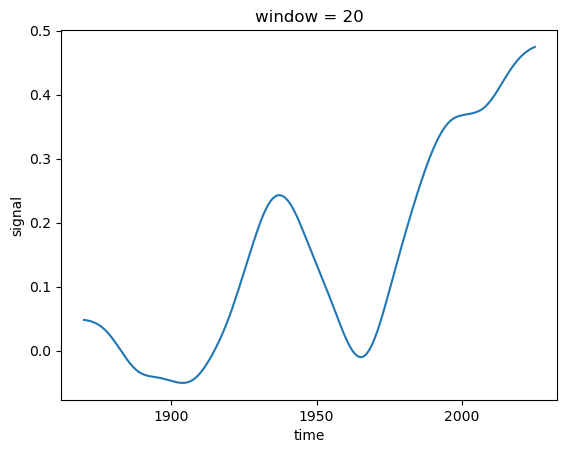

In [30]:
ds_sn_smooth.signal.plot()


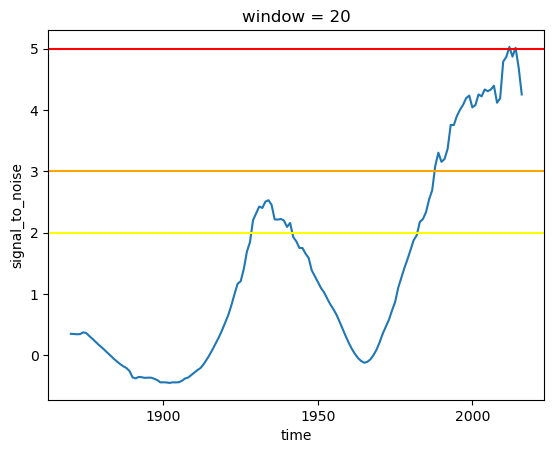

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ds_sn_smooth.signal_to_noise.plot(ax=ax)
ax.axhline(2, color='yellow')
ax.axhline(3, color='orange')
ax.axhline(5, color='red')

## Baseline Signal
This is the signal, but instead of using the gradient, the signal is the change since the base period

In [32]:
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [33]:
base_period_mean_ds = base_period_ds.mean(dim='time')

In [34]:
ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [35]:
window = 20

In [36]:
rolling_mean_ds = ds_smean.rolling(time=window, center=False).mean()
rolling_mean_ds = sn.adjust_time_from_rolling(rolling_mean_ds, window)
rolling_mean_ds

<xarray.DataArray 'temperature' (time: 155)>
nan nan nan nan nan nan nan ... 0.4926 0.5138 0.5293 0.5399 0.5619 0.582 0.6032
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2004-12-31 00:00:00

In [37]:
baseline_signal_ds = rolling_mean_ds - base_period_mean_ds
baseline_signal_ds

<xarray.DataArray 'temperature' (time: 155)>
nan nan nan nan nan nan nan ... 0.7779 0.7992 0.8146 0.8253 0.8473 0.8674 0.8886
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2004-12-31 00:00:00

In [38]:
baseline_signal_ds = baseline_signal_ds.dropna(dim='time')
baseline_signal_ds

<xarray.DataArray 'temperature' (time: 146)>
-0.01656 -0.01244 -0.01258 -0.01367 -0.01219 ... 0.8253 0.8473 0.8674 0.8886
Coordinates:
  * time     (time) object 1859-12-31 00:00:00 ... 2004-12-31 00:00:00

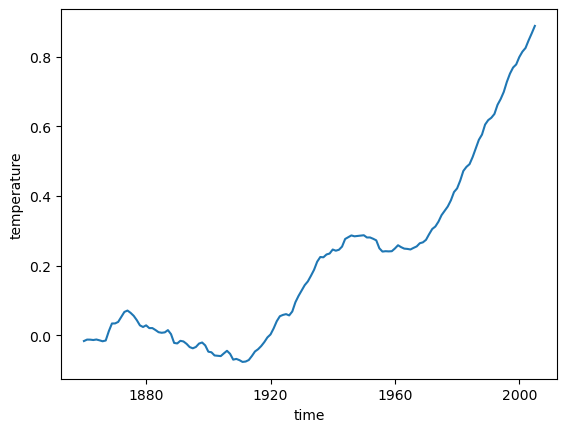

In [39]:
baseline_signal_ds.plot()

In [40]:
noise = sn.noise(ds_smean_detrend_lowess)
noise

<xarray.DataArray 'noise' ()>
0.1075

In [41]:
baseline_sn_ds = baseline_signal_ds/noise
baseline_sn_ds

<xarray.DataArray (time: 146)>
-0.1542 -0.1158 -0.1171 -0.1272 -0.1134 -0.1352 ... 7.582 7.68 7.885 8.072 8.27
Coordinates:
  * time     (time) object 1859-12-31 00:00:00 ... 2004-12-31 00:00:00

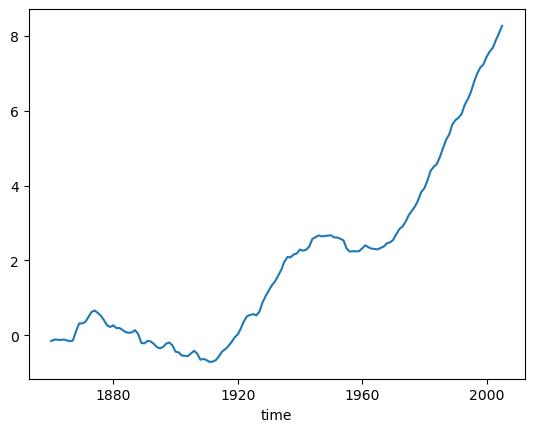

In [42]:
baseline_sn_ds.plot()

## Smoothed Signal

In [43]:
ds_smean_lowess = stats.trend_fit(ds_smean, method='LOWESS', lowess_window=40)

In [44]:
ds_smean_polyfit = stats.trend_fit(ds_smean, method='POLYNOMIAL', order=4)

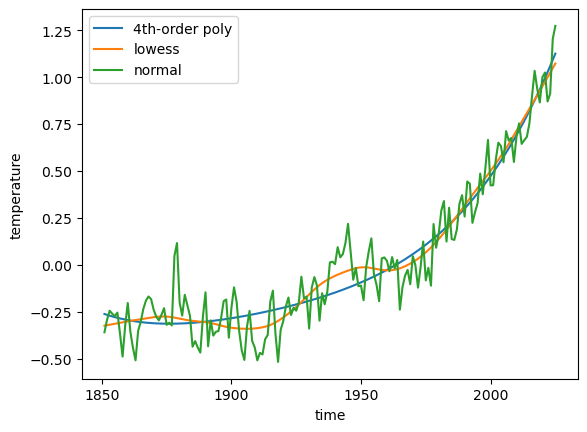

In [45]:
ds_smean_polyfit.plot(label='4th-order poly')
ds_smean_lowess.plot(label='lowess')
ds_smean.plot(label='normal')
plt.legend()

# Probability Ratio

In [46]:
ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

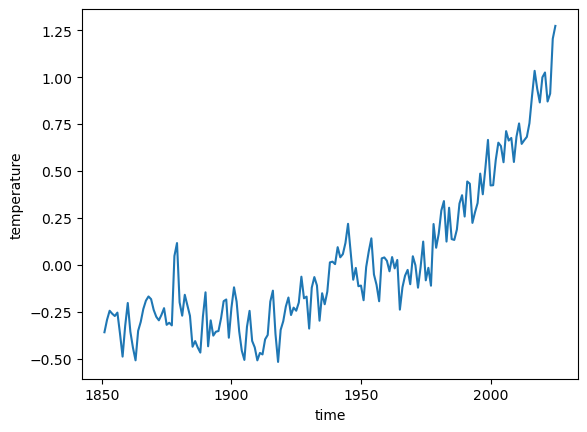

In [47]:
ds_smean.plot()

In [48]:
base_period_percentile_ds = base_period_ds.reduce(np.nanpercentile, q=99.9, dim='time')
base_period_percentile_ds

<xarray.DataArray 'temperature' ()>
0.113

In [49]:
def count_above(ds:xr.Dataset, base_ds:xr.Dataset, threshold:Union[float, int], window:int=20):
    p0_ds = base_ds.where(base_ds>threshold).count()
    ds_above_thresholds = xr.where(ds > threshold, 1, 0)
    p1_ds = ds_above_thresholds.rolling(time=window, center=False).sum()
    p1_ds = sn.adjust_time_from_rolling(p1_ds, window)
    pr = p1_ds/p0_ds
    return pr

In [50]:
pr_ds_percentile = count_above(ds_smean, base_period_ds, base_period_percentile_ds, window=window)
pr_ds_percentile = pr_ds_percentile.dropna(dim='time')
pr_ds_percentile

<xarray.DataArray 'temperature' (time: 146)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0
Coordinates:
  * time     (time) object 1859-12-31 00:00:00 ... 2004-12-31 00:00:00

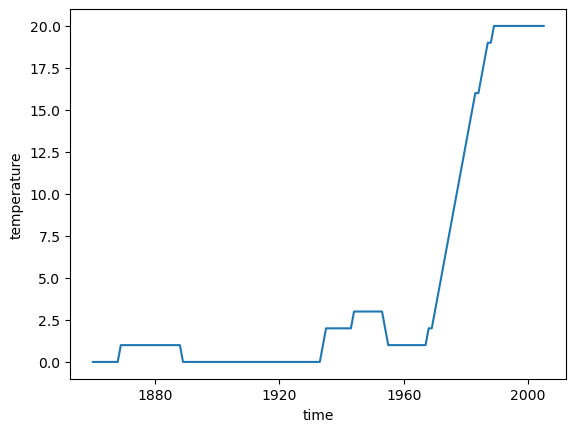

In [51]:
pr_ds_percentile.plot()

# KS test

In [52]:
from scipy.stats import kstest
from functools import partial

In [53]:
kstest_base = partial(kstest, base_period_ds.to_numpy())
def return_kstest_pvalue(arr):
    return kstest_base(arr).pvalue

In [54]:
ks_test_da = (ds_smean
              #.where(~ds_smean.time.isin(base_period_ds.time.values), drop=True)
              .rolling(time=window, center=False).reduce(lambda x, axis: np.apply_along_axis(return_kstest_pvalue, axis, x)))

In [55]:
ks_test_da = sn.adjust_time_from_rolling(ks_test_da, window).dropna(dim='time')

In [56]:
ks_test_da

<xarray.DataArray 'temperature' (time: 146)>
0.9999 0.9999 0.9999 0.9999 0.9999 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 1859-12-31 00:00:00 ... 2004-12-31 00:00:00

In [58]:
# ks_test_da2 = xr.apply_ufunc(
#         return_kstest_pvalue,
#         ds.rolling(time=window, center=False).construct('window_dim'),#[(window-1):],
#         input_core_dims=[['window_dim']],
#         exclude_dims=set(('window_dim',)),
#         vectorize=True,
#         dask='parallelized'
# )

# ks_test_da2 = sn.adjust_time_from_rolling(ks_test_da2, window).dropna(dim='time')

In [59]:
# ks_test_da.plot()
# ks_test_da2.plot(linestyle='--')

# Exceedance

In [60]:
first_sn_exceedance = baseline_sn_ds.where(baseline_sn_ds>2, drop=True).time.values[0]
first_sn_exceedance

cftime.DatetimeGregorian(1935, 12, 31, 0, 0, 0, 0, has_year_zero=False)

In [61]:
pr_ds_percentile.sel(time=first_sn_exceedance).values

array(2.)

In [62]:
ks_test_da.sel(time=first_sn_exceedance).values

array(2.19668959e-08)

In [63]:
first_ks_sig = ks_test_da.where(ks_test_da<0.01, drop=True).time.values[0]
first_ks_sig

cftime.DatetimeGregorian(1927, 12, 31, 0, 0, 0, 0, has_year_zero=False)

In [64]:
first_pr_exceedance = pr_ds_percentile.where(pr_ds_percentile>2, drop=True).time.values[0]
first_pr_exceedance

cftime.DatetimeGregorian(1943, 12, 31, 0, 0, 0, 0, has_year_zero=False)

# Correlation

In [65]:
from scipy.stats import spearmanr

In [66]:
spearmanr(baseline_sn_ds, ks_test_da)

SignificanceResult(statistic=-0.8704871742238335, pvalue=3.5363686712897905e-46)

In [67]:
spearmanr(baseline_sn_ds, pr_ds_percentile)

SignificanceResult(statistic=0.9175659726661245, pvalue=1.5014218825183075e-59)

In [68]:
spearmanr(ks_test_da, pr_ds_percentile)

SignificanceResult(statistic=-0.8096667960529456, pvalue=3.8397053478826837e-35)

# Comparison Plots

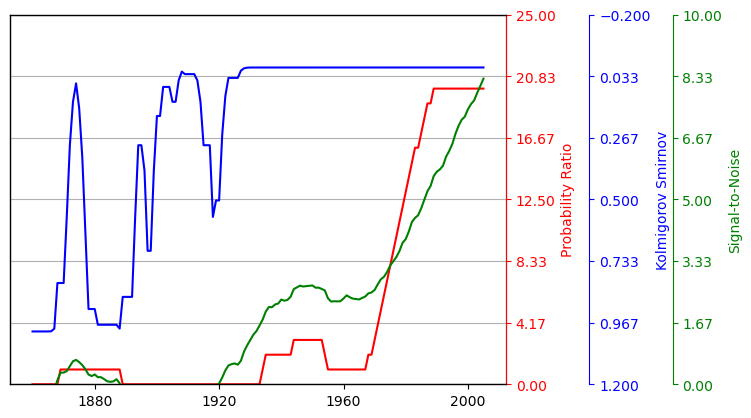

In [69]:
fig, ax_base = plt.subplots()
ax1 = ax_base.twinx()
ax2 = ax_base.twinx()
ax3 = ax_base.twinx()

pr_ds_percentile.plot(ax=ax1, color='red')
ax2.plot(ks_test_da.time.values, np.abs(ks_test_da.to_numpy()-1), c='blue')
# ks_test_da.plot(ax=ax2, yincrease=False, c='blue')
baseline_sn_ds.plot(ax=ax3, c='green')
color_cycle = ['red', 'blue', 'green']

for ax, color in zip([ax1, ax2, ax3],color_cycle):
    ax.spines['right'].set_color(color)
    ax.tick_params(axis='y', color=color, labelcolor=color)

ax2.set_ylim(-0.1, 1.1)

plotting_functions.match_ticks(ax1, ax2)
plotting_functions.match_ticks(ax3, ax2)


ax1.set_ylabel('Probability Ratio', color='red')
ax2.set_ylabel('Kolmigorov Smirnov', color='blue')
ax3.set_ylabel('Signal-to-Noise', color='green')

ax1.set_ylim(np.take(ax1.get_yticks(), [1, -1]))
ax2.set_ylim(np.take(ax2.get_yticks(), [1, -1]))
ax3.set_ylim(np.take(ax3.get_yticks(), [1, -1]))
ax2.set_yticklabels(ax2.get_yticklabels()[::-1])

plotting_functions.match_ticks(ax2, ax1)
plotting_functions.match_ticks(ax2, ax3)


ax2.spines['right'].set_position(('outward', 60))
ax3.spines['right'].set_position(('outward', 120))
ax_base.set_yticklabels([]);
ax_base.set_yticks([])

ax1.grid(True)
# ax.grid(True)

In [86]:
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

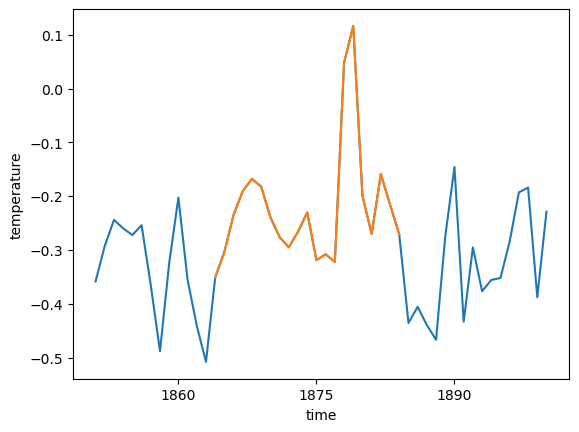

In [87]:
base_period_ds.plot()
ds_smean.sel(time=ds_smean.time.dt.year.isin(np.arange(1863, 1884))).plot()

Text(0, 0.5, 'SN Ratio')

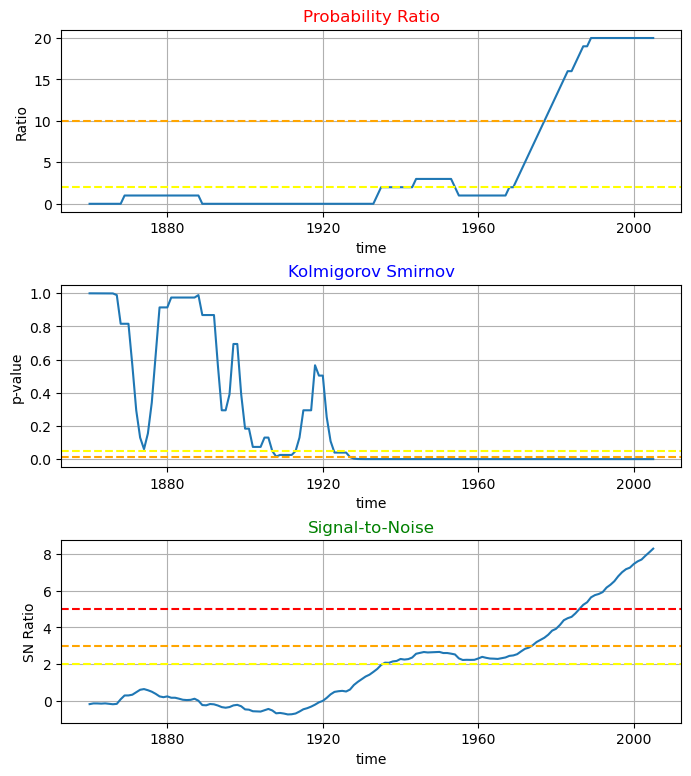

In [70]:
fig = plt.figure(figsize=(8, 9))
gs = gridspec.GridSpec(3, 1, hspace=0.4)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])


# Probability Ratio
pr_ds_percentile.plot(ax=ax1)
ax1.grid(True)
ax1.set_title('Probability Ratio', color='red')
ax1.set_ylabel('Ratio')
ax1.axhline(2, color='yellow', linestyle='--')
ax1.axhline(10, color='orange', linestyle='--')

# KS-test
ks_test_da.plot(ax=ax2)
ax2.grid(True)
ax2.set_title('Kolmigorov Smirnov', color='blue')
ax2.set_ylabel('p-value')
ax2.axhline(0.05, color='yellow', linestyle='--')
ax2.axhline(0.01, color='orange', linestyle='--')

# Signal-to-Noise (baseline)
baseline_sn_ds.plot(ax=ax3)
ax3.axhline(2, color='yellow', linestyle='--')
ax3.axhline(3, color='orange', linestyle='--')
ax3.axhline(5, color='red', linestyle='--')
ax3.set_title('Signal-to-Noise Ratio')
ax3.grid(True)
ax3.set_title('Signal-to-Noise', color='green')
ax3.set_ylabel('SN Ratio')


In [ ]:
# first_sn_exceedance = ds_sn_smooth.signal_to_noise.where(ds_sn_smooth.signal_to_noise>2, drop=True).time.values[0]
# first_sn_exceedance

In [ ]:
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# pr_ds_percentile.plot(ax=ax1, color='green')
# ax1.axhline(1, color='green', linestyle='--')

# ds_sn_smooth.signal_to_noise.plot(ax=ax2)
# ax2.axhline(2, color='yellow', linestyle='--')
# ax2.axhline(3, color='orange', linestyle='--')
# ax2.axhline(5, color='red', linestyle='--')

In [ ]:
# fig = plt.figure(figsize=(8, 9))
# gs = gridspec.GridSpec(3, 1, hspace=0.4)
# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])
# ax3 = fig.add_subplot(gs[2])

# pr_ds_percentile.plot(ax=ax1)
# ax1.grid(True)

# ds_sn_smooth.signal_to_noise.plot(ax=ax2)
# ax2.axhline(2, color='yellow', linestyle='--')
# ax2.axhline(3, color='orange', linestyle='--')
# ax2.axhline(5, color='red', linestyle='--')
# ax2.set_title('Signal-to-Noise Ratio')
# ax2.grid(True)


# baseline_sn_ds.plot(ax=ax3)
# ax3.axhline(2, color='yellow', linestyle='--')
# ax3.axhline(3, color='orange', linestyle='--')
# ax3.axhline(5, color='red', linestyle='--')
# ax3.set_title('Signal-to-Noise Ratio')
# ax3.grid(True)

In [ ]:
fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
pr_ds_percentile.plot(ax=ax)
# ax.axhline(p0_ds_minus_std/p0_ds, color='red', linestyle='--')
# ax.grid(True)



baseline_sn_ds.plot(ax=ax2)
# ax.axhline(2, color='yellow', linestyle='--')
# ax.axhline(3, color='orange', linestyle='--')
# ax.axhline(5, color='red', linestyle='--')
# ax.set_title('Signal-to-Noise Ratio')
ax.grid(True)

- Worker process 2037847 was killed by signal 2
- Worker process 2037844 was killed by signal 2
- Closing Nanny at 'tcp://127.0.0.1:43919'. Reason: nanny-close-gracefully
- Closing Nanny at 'tcp://127.0.0.1:43117'. Reason: nanny-close-gracefully
- Worker process 2037834 was killed by signal 2
- Closing Nanny at 'tcp://127.0.0.1:45499'. Reason: nanny-close-gracefully
- Worker process 2037850 was killed by signal 2
- Closing Nanny at 'tcp://127.0.0.1:43409'. Reason: nanny-close-gracefully
- Worker process 2037829 was killed by signal 6
- Closing Nanny at 'tcp://127.0.0.1:37117'. Reason: nanny-close-gracefully


2024-03-07 13:51:25,341 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-03-07 13:51:25,344 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select

- Worker process 2037838 was killed by signal 2
- Closing Nanny at 'tcp://127.0.0.1:36125'. Reason: nanny-close-gracefully
- Worker process 2037825 was killed by signal 2
- Closing Nanny at 'tcp://127.0.0.1:34795'. Reason: nanny-close-gracefully
